# Experiment with nutpie mass matrix adaptation extended to normalizing flows

Nutpie finds a diagonal mass matrix by minimizing the fisher divergence of the posterior and a transformed posterior:

$$
\min_\eta \int \lVert \nabla \log N(x|0, 1) - \nabla \log \left(F^*_\eta \pi\right)(x) \rVert^2 d\left(F^*_\eta \pi\right)(x)
$$

where $F$ is a family of diffeomorphisms parametrized by $\eta$ and $\pi$ is the posterior density, and $\left(F^*_\eta \pi\right)(x) = \pi(F_\eta(x)) \cdot \lvert\text{det}\nabla F_\eta(x))\rvert$ is the pullback of the posterior density along the diffeomorphism. Note that the integration (and the norm) happens in the transformed space.

If $F_\eta$ is a coordinate-wise affine function $F_\eta(x) = x \odot \eta_\sigma + \eta_\mu$, we can minimize this analytically and get $\eta_\sigma^2 = \sqrt\frac{\text{Var}[X]}{\text{Var}[\nabla \log \pi(X)]}$ and $\eta_\mu = \text{E}[X] + \eta_\sigma \odot \text{E}[\nabla \log \pi(X)]$.

But for other families of diffeomorphisms, we can do the minimization using stochastic gradient decent.

In this notebook we use a familiy of diffeomorphisms defined by a normalizing flow implemented in flowjax.

Usually, we run mass matrix adaptation in windows during tuning, but because this is not yet included into nutpie, we manually sample and update the transformation.

We start sampling with some initial mass matrix.

We take some of those samples, and find a normalizing flow that transforms the posterior into something nicer, by minimizing the fisher divergence defined above.

We then sample for some time with that new transformation, to get some new draws.

After a few iterations the sampler is capable of sampling from quite difficult posteriors.

But other than with normalizing flows in VI, we still have the assurances of hmc/nuts that the samples are actually from the posterior, and diagnostics to figure out problems.

### Problems I see with this so far:

- The optimization can be unreliable. If we want to put something like this into nutpie, it would have to optimizie the normalizing flow without user intervention, and often the optimization only works properly if you change for instance the learning rate or the batch size.
- The fisher divergence restrictes us in the choice of normalizing flows, because the fisher divergence needs efficient forward and backward transformations and jacobian deteminants. Some normalizing flow architectures don't give us that.
- It seems training the neural networks often requires quite a few draws from the posterior, definetly often more than the diagonal mass matrix adaptation. So just 1000 tuning steps might not be enough for non-trivial cases? Perhaps it might be possible to use the full trajectories however, that would give us more training draws, and maybe even work better?
- Not a problem but a random idea: We are pretty close to computing estimators of the fisher information metric on the parameters. Could we use that during the optimization?

# Define model

As a test case we use a model with a 100 dimensional funnel, that also has some correlations.
Nuts based on diagonal mass matrix adaptation can not sample from this at all, as can be seen from the bad effective sample sizes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
%env XLA_FLAGS=--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}

import jax
import flowjax
import nutpie
import pymc as pm
import seaborn as sns
import flowjax.distributions
import flowjax.flows
import jax.numpy as jnp
import equinox as eqx
import flowjax.train
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz
from scipy import linalg
import dataclasses
import optax

jax.config.update("jax_enable_x64", True)

with pm.Model() as model:
    #mu = pm.Normal("mu", sigma=1)
    log_sigma = pm.Normal("log_sigma", sigma=1.)
    sigma = pt.exp(log_sigma)
    pm.Normal("b", sigma=sigma, shape=100)

# Use the jax backend so that we can more easily integrate it with flowjax.
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

trace = nutpie.sample(
    compiled,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    seed=1234,
    #use_grad_based_mass_matrix=False,
)

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/adr/micromamba/envs/lab


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.26,3
,1300,0,0.22,3
,1300,0,0.38,15
,1300,0,0.45,15
,1300,0,0.32,3


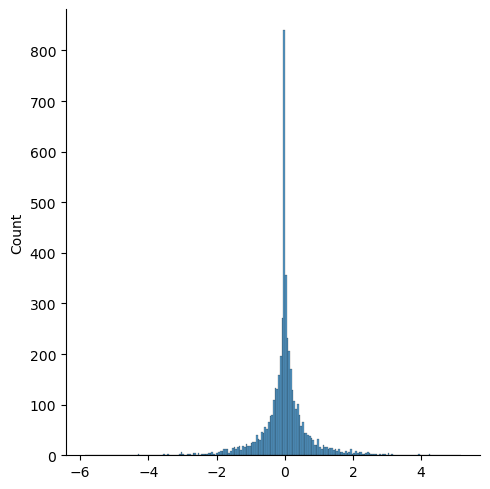

In [3]:
sns.displot(trace.sample_stats.energy_error.values.ravel())

In [4]:
import cloudpickle

In [4]:
with open("../stuff/football-modeling/00_code/001_SFM/model.pickle", "br") as file:
    model = cloudpickle.load(file)

compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

In [9]:
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

trace = nutpie.sample(
    compiled,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    seed=123,
    target_accept=0.8,
    #tune=600,
    draws=10000,
    tune=1000,
    use_grad_based_mass_matrix=False,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,11000,109,0.14,31
,11000,408,0.17,31
,11000,1431,0.18,15
,11000,101,0.06,63
,11000,1124,0.12,63


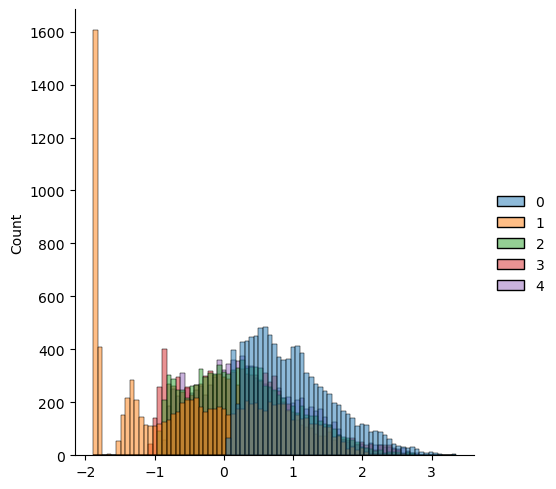

In [6]:
sns.displot(trace.posterior.log_sigma.values.T)

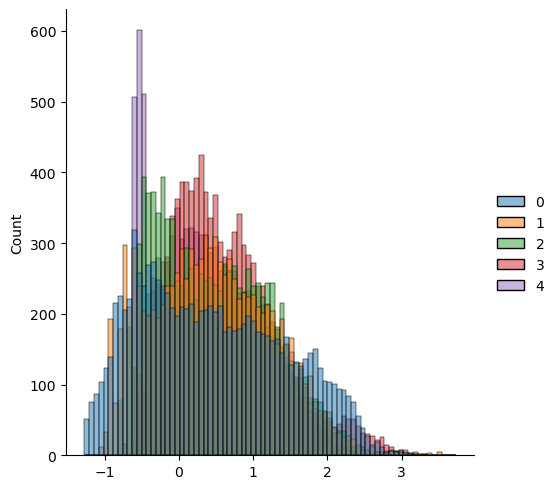

In [8]:
sns.displot(trace.posterior.log_sigma.values.T)

In [8]:
def extract_points(trace):
    draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])
    return jnp.transpose(jnp.array([draws, grads]), [2, 0, 1]), draws.values.T, grads.values.T

points, draws, grads = extract_points(trace)

In [9]:
arviz.ess(trace.sample_stats.unconstrained_draw).min().to_pandas()

unconstrained_draw    8.527482
dtype: float64

In [10]:
#points_nograd, draws_nograd, grads_nograd = extract_points(trace_nograd)

The effective sample sizes are very small, and the sampler clearly did not converge properly.

# Set up a normalizing flow

We set up a small normalizing flow as familiy of diffeomorphisms $F$.
We use a coupling_flow, because this one has good peroformance for both the transform and the inverse transform. We also add a affine layer with the results from the diagonal mass matrix adaptation, to nudge it into the correct region and avoid numerical trouble.

For comparison we also set up two purely affine transformations.

In [11]:
def normalize_model(compiled_model, flow):
    # Terrible hack, needs some support from nutpie...

    make_logp_fn = compiled_model._make_logp_func
    assert make_logp_fn.__code__.co_freevars == ("logp_fn", "logp_shared_names")

    logp_fn = make_logp_fn.__closure__[0].cell_contents._fun.__closure__[1].cell_contents
    logp_shared_names = make_logp_fn.__closure__[1].cell_contents

    make_expand_fn = compiled_model._make_expand_func
    assert make_expand_fn.__code__.co_freevars == (
        "dtypes",
        "expand_fn",
        "expand_shared_names",
        "names"
    )
    dtypes = make_expand_fn.__closure__[0].cell_contents
    expand_fn = make_expand_fn.__closure__[1].cell_contents
    expand_shared_names = make_expand_fn.__closure__[2].cell_contents
    names = make_expand_fn.__closure__[3].cell_contents

    shared = compiled_model._shared_data

    @jax.jit
    def trafo_logp(x):
        def inner_logp(x):
            y, logdet = flow.bijection.transform_and_log_det(x)
            (logp,) = logp_fn(y, *[shared[name] for name in logp_shared_names])
            return logdet + logp

        return jax.value_and_grad(inner_logp)(x)

    def logp_wrapper(x):
        logp, grad = trafo_logp(x)
        return float(logp), np.array(grad, dtype="float64", order="C")

    @jax.jit
    def transform_extract(x, *shared):
        y = flow.bijection.transform(x)
        return expand_fn(y, *shared)
    
    def expand(x):
        values = transform_extract(x, *[shared[name] for name in expand_shared_names])
        return {
            name: np.asarray(val, order="C", dtype=dtype).ravel()
            for name, val, dtype in zip(names, values, dtypes, strict=True)
        }

    return dataclasses.replace(
        compiled,
        _make_logp_func=lambda: logp_wrapper,
        _make_expand_func=lambda seed1, seed2, chain: expand,
    )


def unnormalize_points(trace, flow):
    normalized_draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    normalized_grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])

    def get_untransformed(flow, draw_trafo, grad_trafo):
        draw = flow.bijection.transform(draw_trafo)
        _, pull_grad_fn = jax.vjp(flow.bijection.inverse_and_log_det, draw)
        (grad,) = pull_grad_fn((grad_trafo, 1.))
        return draw, grad

    get_untransformed = jax.vmap(get_untransformed, [None, 0, 0])
    
    draws, grads = get_untransformed(
        flow,
        normalized_draws.values.T,
        normalized_grads.values.T,
    )
    return jnp.transpose(jnp.array([draws, grads]), [1, 0, 2]), draws, grads


def compute_loss(bijection, draw, grad):
    draw, grad, _ = bijection.inverse_gradient_and_val(draw, grad, 0.)
    return ((draw + grad) ** 2).sum()


class FisherLoss:
    @eqx.filter_jit
    def __call__(
        self,
        params,
        static,
        x,
        condition = None,
        key = None,
    ):
        flow = flowjax.train.losses.unwrap(eqx.combine(params, static, is_leaf=eqx.is_inexact_array))

        assert x.shape[1] == 2
        draws = x[:, 0, :]
        grads = x[:, 1, :]

        #norm = sum((val ** 2).sum() for val in jax.tree.leaves(params))

        # We minimize the log of the loss. This seems to work way better,
        # I *think* because the same learning rate works for more cases.
        return jnp.log(jax.vmap(compute_loss, [None, 0, 0])(flow.bijection, draws, grads).mean())# + 1e-8 * norm
        #return jax.scipy.special.logsumexp(jax.vmap(compute_loss, [None, 0, 0])(flow.bijection, draws, grads)) - jnp.log(len(draws))

In [12]:
key = jax.random.PRNGKey(4568786)

diag = np.sqrt(draws.std(0) / grads.std(0))
mean = draws.mean(0) + diag * grads.mean(0)

diag50 = np.sqrt(draws[:50].std(0) / grads[:50].std(0))
mean50 = draws[:50].mean(0) + diag50 * grads[:50].mean(0)

base_dist = flowjax.distributions.Normal(jnp.zeros(compiled.n_dim))
flow_diag = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean, scale=diag),
    ]),
)

flow_diag50 = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

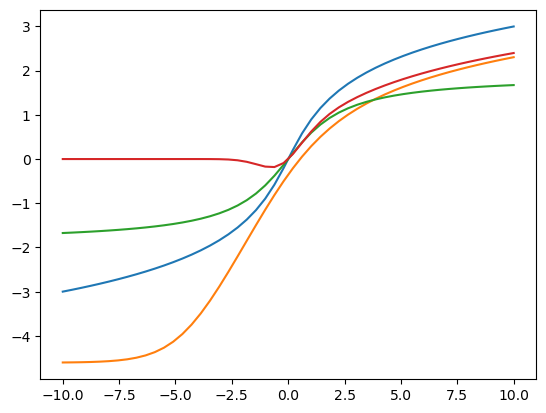

In [13]:
x = np.linspace(-10, 10)
plt.plot(x, np.log(jnp.exp(jnp.arcsinh(x))))
plt.plot(x, np.log(jax.nn.softplus(x) + 1e-2))
clamp = 1.9
plt.plot(x, (2 * clamp / np.pi) * np.arctan(x / clamp))
plt.plot(x, jnp.log(jax.nn.gelu(x) + 1))
#plt.ylim(0., 4)

In [14]:
if False:
    flow_key, key = jax.random.split(key)

    scale = flowjax.wrappers.Parameterize(lambda x: jnp.exp(jnp.arcsinh(x)), jnp.array(0.))
    affine = eqx.tree_at(where=lambda aff: aff.scale, pytree=flowjax.bijections.Affine(), replace=scale)
    flow_templ = flowjax.flows.coupling_flow(
        flow_key,
        base_dist=base_dist,
        invert=True,
        nn_activation=jax.nn.gelu,
        transformer=affine,
    )

    flow = flowjax.flows.Transformed(
        base_dist,
        flowjax.flows.Chain([
            flow_templ.bijection,
            #flowjax.bijections.MvScale(jnp.zeros(compiled.n_dim)),
            flowjax.flows.Affine(loc=mean50, scale=diag50),
        ]),
    )

In [15]:
#import flowjax.bijections.mvscale

In [19]:
key = jax.random.PRNGKey(42)

flows = [
    flowjax.flows.Affine(loc=mean, scale=diag),
]

ndim = int(compiled.n_dim)
n_layers = 8

for i in range(n_layers):
    key, key_couple, key_permute, key_init = jax.random.split(key, 4)

    scale = flowjax.wrappers.Parameterize(lambda x: jnp.exp(jnp.arcsinh(x)), jnp.array(0.))
    affine = eqx.tree_at(where=lambda aff: aff.scale, pytree=flowjax.bijections.Affine(), replace=scale)

    coupling = flowjax.bijections.coupling.Coupling(
        key_couple,
        transformer=affine,
        untransformed_dim=ndim // 2,
        dim=ndim,
        nn_activation=jax.nn.gelu,
        nn_width=ndim // 2,
        nn_depth=1,
    )
    coupling = flowjax.flows.Chain([
        coupling,
        #flowjax.bijections.mvscale.MvScale(
        #    0.1 * jax.random.normal(key_init, ndim),
        #    0.1 * jax.random.normal(key_init, ndim),
        #),
    ])

    if i == n_layers - 1:
        flow = coupling
    else:
        flow = flowjax.flows._add_default_permute(coupling, ndim, key_permute)

    flows.append(flow)

flow = flowjax.flows.Transformed(base_dist, flowjax.bijections.Chain(flows[::-1]))

In [13]:
def _get_untransformed(bijection, draw_trafo, grad_trafo):
    bijection = flowjax.train.losses.unwrap(bijection)
    draw = bijection.inverse(draw_trafo)
    _, pull_grad_fn = jax.vjp(bijection.transform_and_log_det, draw)
    (grad,) = pull_grad_fn((grad_trafo, 1.))
    return draw, grad

pull_points = eqx.filter_jit(jax.vmap(_get_untransformed, [None, 0, 0]))

In [14]:
def fit_flow(key, flow, points, *, method="global", **kwargs):
    draws = points[:, 0]
    grads = points[:, 1]
    if method == "global":
        key, train_key = jax.random.split(key)

        fit, losses, opt_state = flowjax.train.fit_to_data(
            key=train_key,
            dist=flow,
            x=points,
            loss_fn=FisherLoss(),
            **kwargs,
        )

        draws_pulled, grads_pulled = pull_points(fit.bijection, draws, grads)
        print(np.log(((draws_pulled + grads_pulled) ** 2).sum(1).mean(0)))
        return fit, opt_state
    elif method == "layered":
        opt_state = kwargs.pop("opt_state", None)
        if opt_state is None:
            opt_state = [None] * (len(flow.bijection.bijections) - 1)

        diag = np.sqrt(draws.std(0) / grads.std(0))
        mean = draws.mean(0) + diag * grads.mean(0)
        diag_flow = flowjax.flows.Affine(loc=mean, scale=diag)

        draws_pulled, grads_pulled = pull_points(diag_flow, draws, grads)
        print(np.log(((draws_pulled + grads_pulled) ** 2).sum(1).mean(0)))

        layers = [diag_flow]
        new_states = []

        for bijection, opt_state in zip(reversed(flow.bijection.bijections[:-1]), opt_state):
            key, train_key = jax.random.split(key)
            fit_layer, losses, opt_state = flowjax.train.fit_to_data(
                key=train_key,
                dist=flowjax.flows.Transformed(base_dist, bijection),
                x=jnp.transpose(jnp.array([draws_pulled, grads_pulled]), [1, 0, 2]),
                loss_fn=FisherLoss(),
                **kwargs,
            )

            new_states.append(opt_state)
            layers.append(fit_layer.bijection)

            draws_pulled, grads_pulled = pull_points(fit_layer.bijection, draws_pulled, grads_pulled)
            print(np.log(((draws_pulled + grads_pulled) ** 2).sum(1).mean(0)))

        return flowjax.flows.Transformed(base_dist, flowjax.bijections.Chain(layers[::-1])), new_states
    else:
        assert False

In [15]:
def adapt_window(key, compiled, points, flow, *, num_train=None, opt_state=None, optimization_kwargs=None, sample_kwargs=None):
    if optimization_kwargs is None:
        optimization_kwargs = {}
    if sample_kwargs is None:
        sample_kwargs = {}

    defaults = {
        "max_epochs": 600,
        #"batch_size": min(len(points) // 10, 128),
        "batch_size": 128,
        "optimizer": optax.adabelief(1e-3),
        #"max_patience": 100,
        "return_best": False,
        "val_prop": 0.1,
    }

    defaults.update(optimization_kwargs)

    key, train_key = jax.random.split(key)

    fit, opt_state = fit_flow(train_key, flow, points, method="global", **defaults)
    losses = None

    compiled_trafo = normalize_model(compiled, fit)

    trace_trafo = nutpie.sample(
        compiled_trafo,
        store_gradient=True,
        store_unconstrained=True,
        store_mass_matrix=True,
        seed=int(np.uint64(int(key[0]) + int(key[1]) * 2**32)),
        **sample_kwargs,
    )

    points, *_ = unnormalize_points(trace_trafo, fit)

    return trace_trafo, points, fit, losses, opt_state

In [16]:
# Some ugly gymnastics to get the logp function from nutpie...
logp_fn_ = compiled._make_logp_func().__closure__[0].cell_contents
logp_fn = lambda x: logp_fn_._fun.__closure__[1].cell_contents(x)[0]

elbo_loss = flowjax.train.losses.ElboLoss(logp_fn, num_samples=100, stick_the_landing=True)
elbo_loss_large = flowjax.train.losses.ElboLoss(logp_fn, num_samples=4000, stick_the_landing=True)

In [17]:
%%time
key = jax.random.PRNGKey(45648965465)

sample_kwargs = {
    "progress_bar": False,
    "chains": 4,
    "draws": 100,
    "target_accept": 0.9,
}

trace = nutpie.sample(
    compiled,
    store_gradient=True,
    store_unconstrained=True,
    seed=123,
    **sample_kwargs,
)

points, *_ = extract_points(trace)
opt_state = None

fit_trace = [flow]
trace_trace = [trace]
point_trace = [points]
loss_trace = []
opt_state_trace = []

fit = fit_trace[-1]
for i in range(30):
    if i % 10 == 0:
        opt_state = None
    key, key_window = jax.random.split(key)
    trace_update, points, fit, losses, opt_state = adapt_window(
        key_window,
        compiled,
        #points,
        np.concatenate(point_trace[-15:], axis=0),
        fit,
        sample_kwargs=sample_kwargs,
        opt_state=opt_state,
    )
    params, static = eqx.partition(fit, eqx.is_inexact_array)
    print("tuning-logp-evals", int(trace.warmup_sample_stats.n_steps.sum().values))
    print("sampling-logp-evals", int(trace.sample_stats.n_steps.sum().values))
    print("log-elbo:", np.log(elbo_loss_large(params, static, key)))
    print("divs:", int(trace_update.sample_stats.diverging.sum().values))
    print("ess:", float(arviz.ess(trace_update.sample_stats.unconstrained_draw).min().unconstrained_draw.values))
    fit_trace.append(fit)
    #trace_trace.append(trace_update)
    point_trace.append(points)
    loss_trace.append(losses)
    opt_state_trace.append(opt_state)

  0%|          | 0/600 [00:00<?, ?it/s]


AttributeError: 'Chain' object has no attribute 'inverse_gradient_and_val'

In [21]:
final_model = normalize_model(compiled, fit)

In [22]:
trace_final = nutpie.sample(final_model, store_unconstrained=True, store_gradient=True, seed=123, chains=4)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,2,0.41,15
,1300,0,0.41,15
,1300,0,0.42,15
,1300,0,0.40,15


In [24]:
points, _, _ = unnormalize_points(trace_final, fit)

In [28]:
# Some ugly gymnastics to get the logp function from nutpie...
logp_fn_ = compiled._make_logp_func().__closure__[0].cell_contents
logp_fn = lambda x: logp_fn_._fun.__closure__[1].cell_contents(x)[0]

elbo_loss = flowjax.train.losses.ElboLoss(logp_fn, num_samples=100, stick_the_landing=True)
elbo_loss_large = flowjax.train.losses.ElboLoss(logp_fn, num_samples=1000, stick_the_landing=True)

In [30]:
# alex, 128 batch, simple loss, 100 draws, 15 windows, mvscale layer, exp decay loss
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points[:1000])), np.log(elbo_loss_large(params, static, key)))

13.62360963426312 10.151509330076092
5.723198659640157 10.11995390128279
4.78168479389497 10.118752385506188
4.106468747759502 10.118402410951306
3.5607601868104526 10.118242799722331
3.2665716527157054 10.118189922518884
2.962449782445716 10.118143275949171
2.7915941214725377 10.118125394941359
2.6438107482225432 10.11811462714134
2.487484583405129 10.11810079876914
2.355185881106131 10.118095073851395
2.2465077104728928 10.118086844913273
2.1485067474390305 10.118079729663075
2.11514130418148 10.118075966673404
1.989107118772965 10.11807301094638
1.852942441007411 10.118070408693812
1.841654375540518 10.118066776564588
1.7302519246761425 10.118064954498724
1.7231815381477924 10.118067907633446
1.6505759980396622 10.118065506274952
1.5978730984015042 10.118064637984721
1.5687828101712262 10.118060437580068
1.5481659910550292 10.118059032115553
1.4872725263758364 10.118058360901427
1.5292035506815866 10.11806112504562
1.4737964633872236 10.118061346035384
1.38719594304471 10.1180564155

In [99]:
# 256 batch, simple loss, 100 draws, 15 windows, mvscale layer, exp decay loss
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

133.2330257729824 5.40904726166171
48.79842732973731 2.7673922579709296
40.67276484850806 1.1740632498057468
19.640220668786665 0.6569947597549006
42.06927281084767 0.3810867914659392
31.370205865282745 0.20634639071557934
9.065296768849644 0.06574309849197149
6.7529146536466405 -0.09040254901567828
6.481987141385158 -0.2312511123915401
6.160365384533929 -0.3170370244481564
5.0426776720087165 -0.4300983395076551
4.260645729855353 -0.5172528392044128
4.218159401810904 -0.6189728955345343
4.220130457417462 -0.6643018477451308
3.9926610842808556 -0.7103846638072046
3.820941887233979 -0.7156544846576002
3.7517003923809455 -0.7818228054456828
3.7017985917538514 -0.8462777966629254
3.702897856546373 -0.8582967167583134
3.703049267826472 -0.8702215919119534
3.6801215649580254 -0.9196833443578657
3.6873191772312826 -0.9473073435313066
3.6573976800065893 -0.9574295484143738
3.6552082019022816 -0.9629036108354392
3.6441728571974688 -0.9968795055142476
3.649016607459921 -0.9999853696110031
3.6537

In [53]:

# 256 batch, simple loss, 100 draws, 15 windows
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

201.07953462453005 4.7506429352720305
31.62608874989956 2.820229937195545
5.1642860999060565 1.681075798188687
3.5130412940519324 0.6885886250640757
3.2016554728254136 0.4440939984777006
2.816284826961632 0.1678362486551378
2.4482087844361327 -0.09941707167827533
2.312837300284747 -0.2112453112020255
2.2264088089433622 -0.26983671261142494
2.0344731566823984 -0.4042024195243965
1.9403530933545694 -0.48901582584884046
1.6327596042510244 -0.727641010953736
1.5701069639923237 -0.7653101915450258
1.4183794789902957 -0.8951000525212394
1.3769143123999208 -0.8501649668063874
0.8934019905598718 -1.2975237622845246
0.735550714814766 -1.5143702913410264
0.6693765924156408 -1.4489055337266115
0.6352018838536997 -1.4459973739032042
0.5789182771465459 -1.4913369508382073
0.40307917505275354 -1.7365089232813014
0.41244332499487535 -1.6810053216599568
0.3706384608210181 -1.8195317006553537
0.316479274989084 -1.6941045959219834
0.1720214467445275 -1.8714244674898266
0.15659339097065464 -1.93528992268

In [154]:
# alex model, exp(arcsinh), gelu activation
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

nan 5.948621020696048
6.474576306200823 2.1605105343456077
3.2648783211448613 0.42913867677765843
2.463458334726814 -0.14610459568499812
1.6925873061298373 -0.7131612752486416
1.2704375604568703 -0.9376300534335632
1.004279284294392 -1.2084717071640025
0.8864042522666502 -1.246061438855377
0.686931775046007 -1.5358609086362434
0.7720564012752602 -1.3411972357351187
0.3276048033340613 -1.6014915653325243
0.231630541444292 -1.830311517356041
0.7496354959984999 -1.5019788616202623
0.15527563216090048 -1.6618292819230807
0.08104342300334674 -1.8498283237780473
0.3755620914859733 -1.6585804318221264
-0.12979318907135967 -2.1931211875200285
0.13724070555764276 -1.916739809126357
-0.052273924237212575 -1.9615019615726739
-0.04104889323003056 -1.9129252277122097
0.03738379069285601 -1.7693690193415759
-0.14763676906782222 -2.1916137675960563
-0.2434678670470643 -2.169400751650714
-0.08678816075010654 -2.2262906440235963
-0.2395833031291949 -2.1577256586038205
-0.26374043174445916 -2.2883153940

In [36]:
# alex model, exp(arcsinh), gelu activation
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

332.6318798184707 5.40904726166171
119.66800618001609 3.0884654172032273
5.224196679061699 1.490096542114466
3.6674554545550673 0.48024209928234834
3.303112488213128 0.24353717629942712
2.8746157415240514 -0.1314452300885502
2.5873201851790077 -0.32065847106402023
2.2619975499369662 -0.5107316691738063
2.053250235936822 -0.7848160336742444
2.0048439473622075 -0.7875133442848026
1.9893116161305562 -0.9033576304428721
1.829688027673951 -0.998667534180642
1.7908310937920737 -1.052614140086124
1.6053165525948359 -1.2778412983861185
1.5201592341122148 -1.3549881060614766
1.5161416434955344 -1.2533053607198206
1.5551338255204794 -1.4808429404562569
1.3636201978221303 -1.6459077807208038
1.23859057583772 -1.6058424965266362
1.102726270356569 -1.4829700248738489
0.9450399938236778 -1.6119052975582118
0.836315749116851 -1.6092085758377244
0.7841136409139402 -1.6906121333017132
0.9971178751046299 -1.4426147894506793
0.8577764797598562 -1.5684056757809397
0.6863604862777166 -1.7189720632538765
0.

In [43]:
# alex model, exp(arcsinh), gelu activation
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

nan 10.124354810752301
4.912531102860933 10.120377430884142
4.429236464420146 10.119259002085224
4.072817647250413 10.118781927524054
3.8079455319241236 10.118451207242712
3.658180494572947 10.118370394317726
3.494911819022252 10.118308993630192
3.3963060552352418 10.118271532318001
3.269466976782447 10.118216910230917
3.3039381148795615 10.118283127176577
3.1646405369307544 10.118196625328899
3.1699527057362293 10.11822013823807
3.1101445108014314 10.118216348491964
3.066235567334068 10.118192188125498
2.9836830629458877 10.118180111765597
2.9304434923137452 10.118166304114824
2.890094028215939 10.11817025183919
2.830685690573578 10.118157632539491
2.72927935898048 10.118144211404983
2.769163873167588 10.11813910185233
2.736939319992026 10.118149095903838


In [101]:
# exp(arcsinh), gelu activation, depth2
for fit in fit_trace:
    params, static = eqx.partition(fit, eqx.is_array)
    print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

487.2987974338254 3.3960493218708896
4.20662402538244 -0.36844895155715396
2.8215149445550547 -0.798525111668875
1.5960744364114678 -1.2543729565478878
1.1832837228534032 -1.2922378944469595
1.0128304617609678 -1.364316585389419
0.9219123506922589 -1.4702975142500854
0.7620680391516947 -1.6271275444914828
0.6622069180654576 -1.6923870778800196
0.4293015765701962 -1.8282788267122456
0.40790633756585315 -1.8319583486176694
0.40659752941051036 -1.6756029931406553
0.2601093937734033 -1.9420070344443474
0.2919162911895618 -1.9269666713461824
0.203533854444443 -2.168611095196275
0.2261943831141351 -2.1047807965781193
0.1553846253381068 -2.1356679263087366
0.17675862708266246 -2.115060728066095
0.04652010621659361 -2.2026571427933965
-0.013705371164625321 -2.0651202132612028
0.15268912362348924 -1.9821188946646975


In [54]:
adapt_error = (trace_final.sample_stats.gradient + trace_final.sample_stats.unconstrained_draw) ** 2

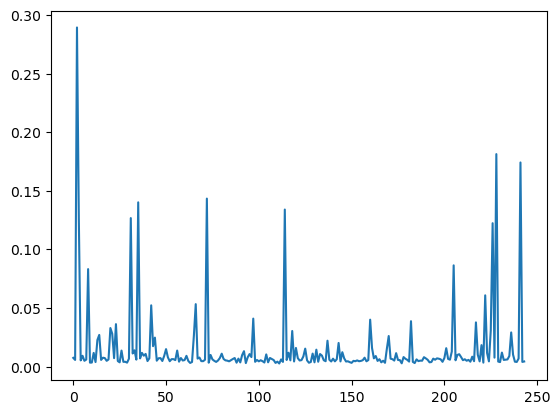

In [110]:
plt.plot(adapt_error.mean(["chain", "draw"]))

In [57]:
mean_adapt_error = adapt_error.sum("unconstrained_parameter")

In [63]:
import perpetual

In [64]:
predictor = perpetual.PerpetualBooster(objective="SquaredLoss")

In [84]:
res = predictor.fit(np.array(points[:, 0]), np.log(mean_adapt_error.values.ravel()))

In [85]:
importances = res.calculate_feature_importance()

In [86]:
import pandas as pd

In [87]:
importances = pd.Series(importances)

In [88]:
importances.sort_values()

177    0.000462
3      0.000582
31     0.000607
111    0.000666
126    0.000667
         ...   
241    0.032777
1      0.037611
147    0.088119
146    0.152388
145    0.154006
Length: 244, dtype: float64

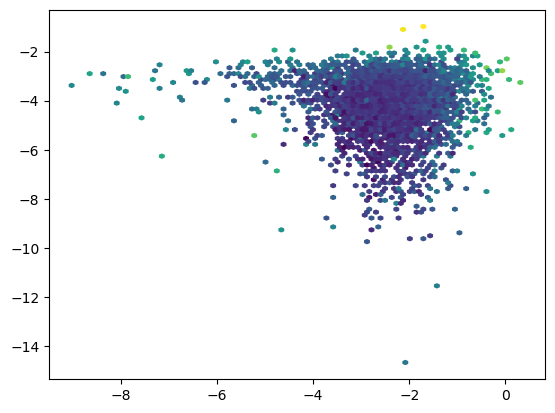

In [106]:
plt.hexbin(points[:, 0, 146], points[:, 0, 145], C=np.log(mean_adapt_error.values.ravel()))

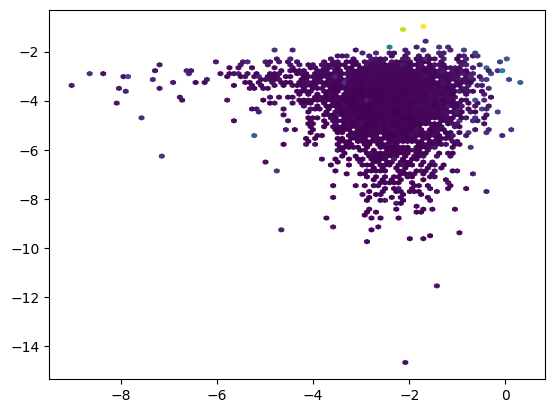

In [107]:
plt.hexbin(points[:, 0, 146], points[:, 0, 145], C=mean_adapt_error.values.ravel())

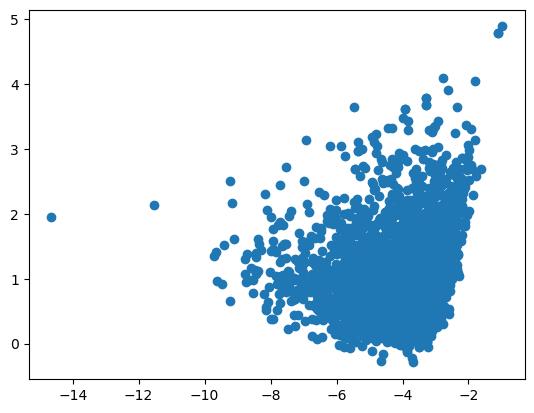

In [100]:
plt.scatter(points[:, 0, 145], np.log(mean_adapt_error.values.ravel()))

In [98]:
trace_final.sample_stats.unconstrained_parameter[241]

<xarray.DataArray 'unconstrained_parameter' ()> Size: 84B
array('cutpoints_ordered___0', dtype='<U21')
Coordinates:
    unconstrained_parameter  <U21 84B 'cutpoints_ordered___0'

In [95]:
trace_final.sample_stats.unconstrained_parameter[145]

<xarray.DataArray 'unconstrained_parameter' ()> Size: 68B
array('amplitude_log___0', dtype='<U17')
Coordinates:
    unconstrained_parameter  <U17 68B 'amplitude_log___0'

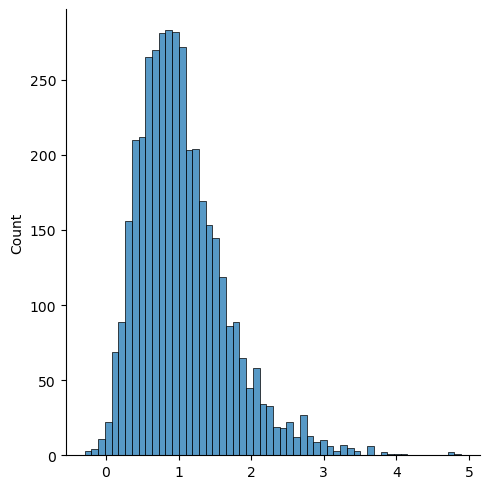

In [60]:
sns.displot(np.log(mean_adapt_error.values.ravel()))

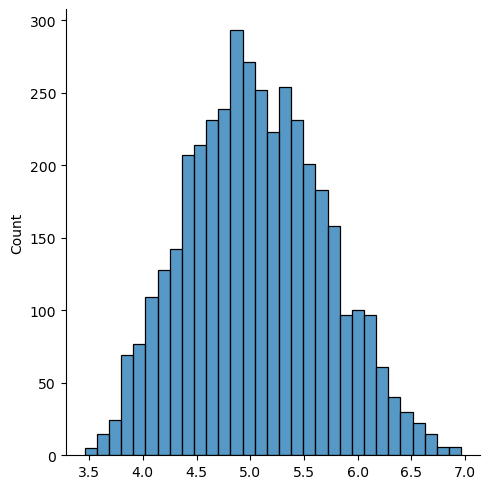

In [51]:
sns.displot(np.log(((points[:, 0] + points[:, 1]) ** 2).mean(1)))

# Run VI just for comparison

We can also minimize the elbo to approximate the posterior.
At least the way I'm doing it here this does require quite a lot
of logp evaluations however, and also doesn't seem to fit the posterior
all too well.

In [20]:
# Some ugly gymnastics to get the logp function from nutpie...
logp_fn_ = compiled._make_logp_func().__closure__[0].cell_contents
logp_fn = lambda x: logp_fn_._fun.__closure__[1].cell_contents(x)[0]

elbo_loss = flowjax.train.losses.ElboLoss(logp_fn, num_samples=100, stick_the_landing=True)
elbo_loss_large = flowjax.train.losses.ElboLoss(logp_fn, num_samples=1000, stick_the_landing=True)

In [24]:
key, train_key = jax.random.split(key)

vi_fit, losses = flowjax.train.fit_to_variational_target(
    train_key, flow, elbo_loss, learning_rate=1e-2, steps=300, optimizer=optax.adabelief(1e-3),
)

100%|██████████| 300/300 [00:11<00:00, 25.65it/s, loss=3.66]


In [25]:
first_affine = flowjax.bijections.Affine(loc=vi_fit.base_dist.loc, scale=vi_fit.base_dist.scale)
vi_fit_fixed = flowjax.flows.Transformed(base_dist, flowjax.bijections.Chain([first_affine, *vi_fit.bijection.bijections]))

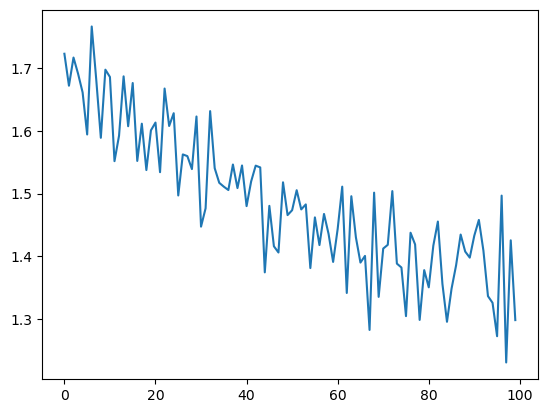

In [26]:
plt.plot(np.log(losses)[200:])

In [35]:
np.log(np.min(losses))

10.118061648753036

## Some hacky code to transform nutpie models

We set up some helper functions to transform our model and the resulting draws.

In [36]:
# Fisher divergence of the flow without any fitting
params, static = eqx.partition(flow, eqx.is_array)
float(FisherLoss()(params, static, points))

12.263154040292129

In [39]:
# Fisher divergence of the flow without any fitting
params, static = eqx.partition(fit, eqx.is_array)
print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

1.3151073154532475 10.118051439181288


In [40]:
# TODO include vi_fit base_dist??

In [41]:
params, static = eqx.partition(vi_fit, eqx.is_array)
print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

3.739800992785239 10.118082335577569


In [42]:
# Fisher divergence of the VI fit
params, static = eqx.partition(vi_fit_fixed, eqx.is_array)
print(float(FisherLoss()(params, static, points)), np.log(elbo_loss_large(params, static, key)))

2.867466528680815 10.118082335577569


In [43]:
# Fisher divergence of the nutpie diagonal mass matrix approximation
params, static = eqx.partition(flow_diag, eqx.is_array)
float(FisherLoss()(params, static, points))

6.014146804828456

In [44]:
# Fisher divergence of the nutpie diagonal mass matrix approximation with 50 draws
params, static = eqx.partition(flow_diag50, eqx.is_array)
float(FisherLoss()(params, static, points))

7.233267872963363

# First fisher divergence minimization run

We use 1000 draws from our posterior approximation to fit the normalizing flow, and keep the other draws for validation. This isn't exaclty fast, but at least it doesn't need to do any extra logp evaluations. So if the logp function is slow, this will still take the same amount of time.

In [40]:
import optax

In [41]:
schedule = optax.warmup_cosine_decay_schedule(
  init_value=1e-4,
  peak_value=1.0,
  warmup_steps=10,
  decay_steps=200,
  end_value=0.0,
)

optimizer = optax.chain(
  optax.clip(0.01),
  optax.adamw(learning_rate=1e-3),
)

In [43]:
train_key, key = jax.random.split(key)
optimizer = optax.adabelief(1e-3)
fit, data, _ = flowjax.train.fit_to_data(
    key=train_key,
    dist=flow,
    x=jnp.array(points[:4000]),
    batch_size=128,
    learning_rate=1e-3,
    max_epochs=400,
    max_patience=20,
    loss_fn=FisherLoss(),
    optimizer=optimizer,
)

 35%|███▍      | 139/400 [00:14<00:26,  9.83it/s, train=1.4837222243430028, val=4.102451074778336 (Max patience reached)]


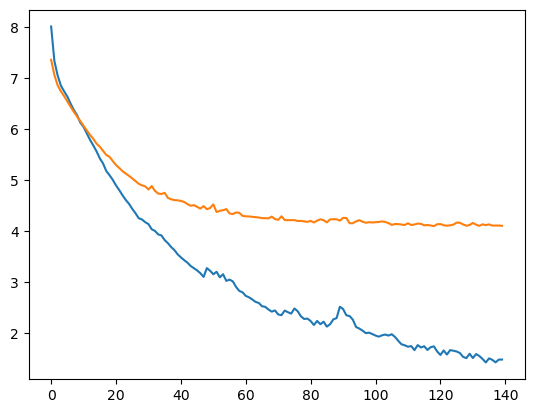

In [44]:
plt.plot(np.array(data["train"]))
plt.plot(np.array(data["val"]))

In [46]:
# Fisher divergence of the fit on the validation dataset
params, static = eqx.partition(vi_fit, eqx.is_array)
float(FisherLoss()(params, static, points[4000:])), np.log(elbo_loss_large(params, static, key))

(nan, 10.118320308417314)

In [47]:
# Fisher divergence of the fit on the validation dataset
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points[4000:])), np.log(elbo_loss_large(params, static, key))

(nan, 10.124483839286452)

## Some plots about the fit

We can now sample from the normal distribution on the transformed space, and
transform those draws with our learned transformation. Ideally, they look similar to the posterior.

In [48]:
sample_key, key = jax.random.split(key)
samples = fit.sample(sample_key, (6000,))

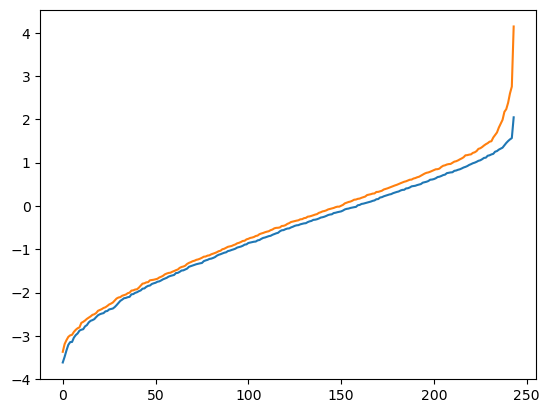

In [49]:
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.cov(samples.T))))
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.diag(diag ** 2))))

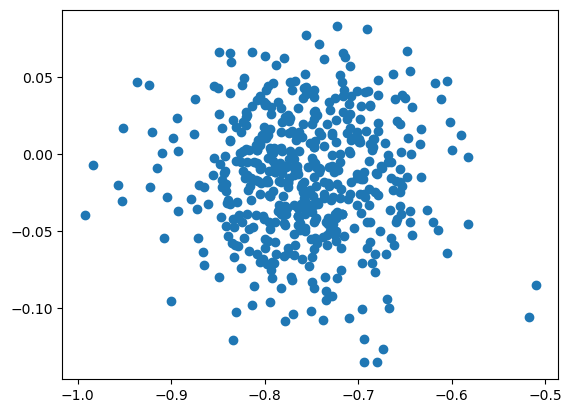

In [50]:
plt.scatter(draws[:, 0], draws[:, 2:].mean(1))

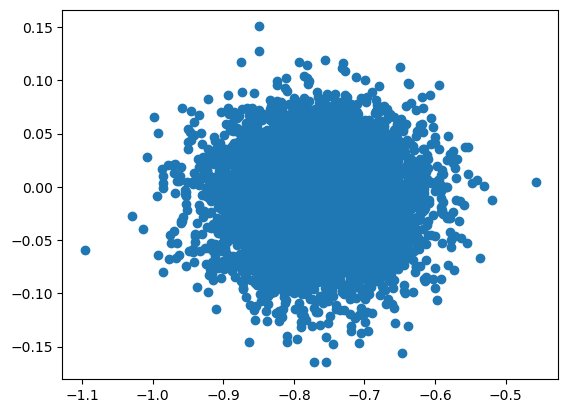

In [51]:
plt.scatter(samples[:, 0], samples[:, 2:].mean(1))

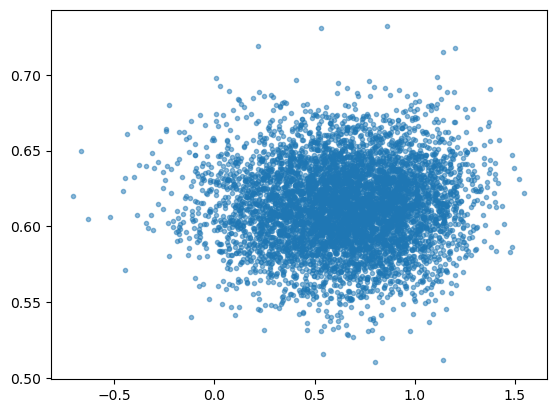

In [52]:
i = 1
j = -1
plt.scatter(samples[:, i], samples[:, j], alpha=0.5, marker=".")
#plt.scatter(draws[i], draws[j], alpha=0.5, marker=".")
#plt.xlim((-40, 40))

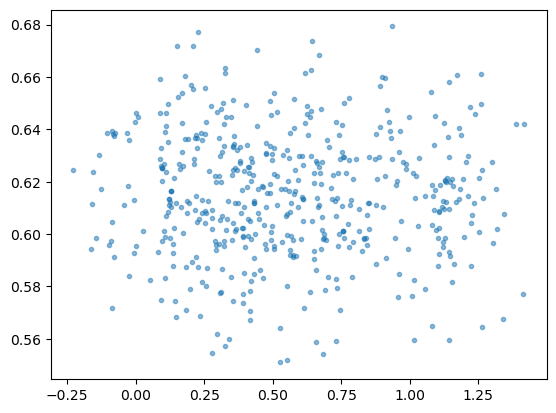

In [53]:
plt.scatter(draws[:, i], draws[:, j], alpha=0.5, marker=".")

We can also transform our (bad) posterior draws and see how well they seem to fit a standard normal distribution

In [54]:
draws_trafo = jax.vmap(fit.bijection.inverse, in_axes=[0])(draws)

<Axes: ylabel='Density'>

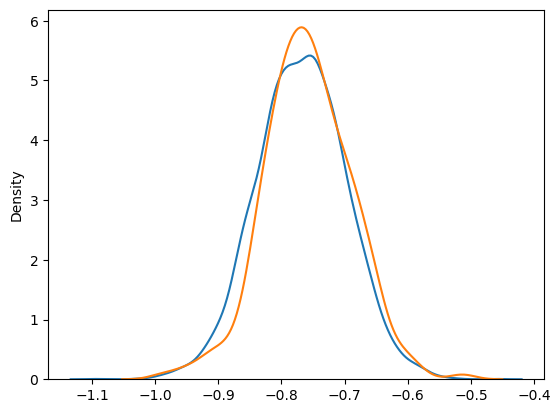

In [55]:
sns.kdeplot(samples[:, 0])
sns.kdeplot(draws[:, 0])

# Sample again, but now in the transformed space that we just learned.

In [56]:
compiled2 = normalize_model(compiled, fit)

trace2 = nutpie.sample(
    compiled2,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=1234,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,70,0.22,15
,1300,44,0.20,31
,1300,139,0.17,31
,1300,64,0.21,31
,1300,157,0.25,3


In [57]:
arviz.ess(trace2.sample_stats.unconstrained_draw).min().to_pandas()

unconstrained_draw    196.70125
dtype: float64

In [58]:
compiled2_vi = normalize_model(compiled, vi_fit)
trace2_vi = nutpie.sample(
    compiled2_vi,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=1234,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,52,0.24,15
,1300,20,0.16,31
,1300,232,0.20,31
,1300,39,0.19,31
,1300,37,0.19,31


In [59]:
arviz.ess(trace2_vi.sample_stats.unconstrained_draw).min().to_pandas()

unconstrained_draw    45.206782
dtype: float64

In [60]:
points2, draws2, grads2 = unnormalize_points(trace2, fit)

# Repeat the fit and sample once more

The sampler is already mostly fine, but we can repeat this again to get a better fit

In [61]:
import optax

In [63]:
fit2, data, _ = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit,
    x=points2[:4000],
    batch_size=64,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
    #optimizer=optax.adamaxw(1e-3),
    #optimizer=opt,
)

100%|██████████| 200/200 [02:13<00:00,  1.50it/s, train=0.8974140175113263, val=1.643308244989816] 


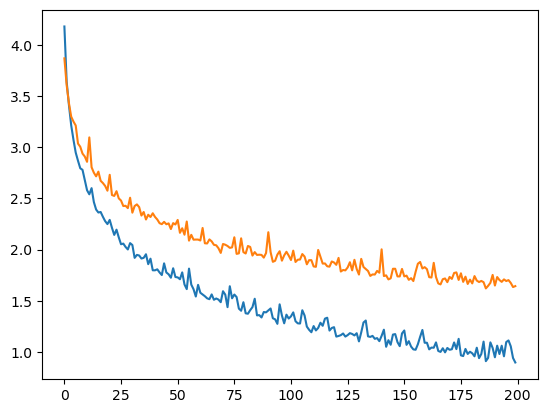

In [64]:
plt.plot(data["train"])
plt.plot(data["val"])

In [65]:
params, static = eqx.partition(vi_fit, eqx.is_array)
float(FisherLoss()(params, static, points2[4000:])), float(np.log(elbo_loss_large(params, static, key)))

(5.913392834479718, 10.118314692525729)

In [66]:
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points2[4000:])), float(np.log(elbo_loss_large(params, static, key)))

(4.756996034598056, 10.124473221115991)

In [67]:
params, static = eqx.partition(fit2, eqx.is_array)
float(FisherLoss()(params, static, points2[4000:])), float(np.log(elbo_loss_large(params, static, key)))

(2.1853012306366018, 10.118074848586645)

In [68]:
compiled3 = normalize_model(compiled, fit2)

trace3 = nutpie.sample(
    compiled3,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=123456,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,24,0.36,15
,1300,28,0.36,15
,1300,26,0.38,15
,1300,24,0.37,15
,1300,6,0.36,15


In [69]:
arviz.ess(trace3.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(3944.56857794)

In [70]:
points3, draws3, grads3 = unnormalize_points(trace3, fit2)

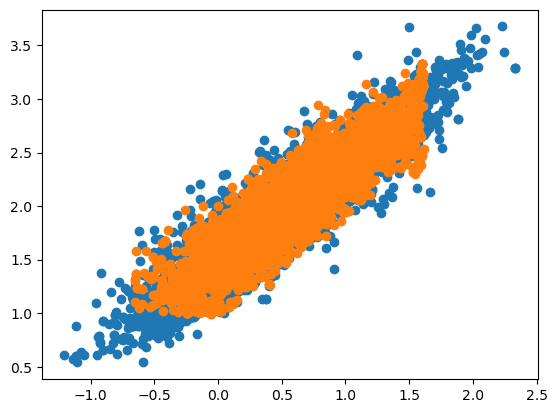

In [71]:
i = 1
j = -3
plt.scatter(draws3[:, i], draws3[:, j])
plt.scatter(draws2[:, i], draws2[:, j])

In [73]:
fit3, data, _ = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit2,
    x=points3[:4000],
    batch_size=32,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
    optimizer=optax.adamaxw(1e-3)
)

 42%|████▎     | 85/200 [01:37<02:11,  1.14s/it, train=0.735198439291222, val=1.618792295030233 (Max patience reached)]


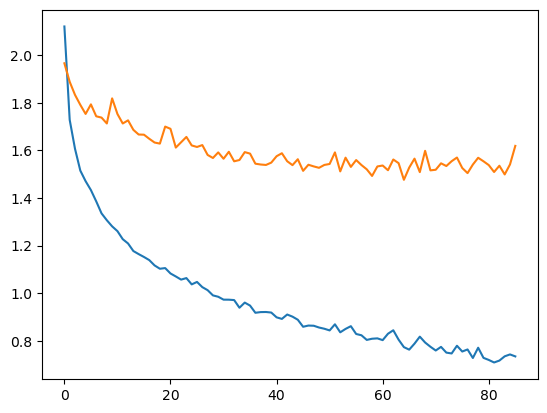

In [74]:
plt.plot(data["train"])
plt.plot(data["val"])

In [75]:
params, static = eqx.partition(flow_diag50, eqx.is_array)
float(FisherLoss()(params, static, points3[4000:])), np.log(elbo_loss_large(params, static, key))

(7.622365762711986, 10.872467553137419)

In [76]:
params, static = eqx.partition(vi_fit, eqx.is_array)
float(FisherLoss()(params, static, points3[4000:])), np.log(elbo_loss_large(params, static, key))

(8.163532328723406, 10.118314692525729)

In [77]:
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points3[4000:])), np.log(elbo_loss_large(params, static, key))

(5.09961647517758, 10.124473221115991)

In [78]:
params, static = eqx.partition(fit2, eqx.is_array)
float(FisherLoss()(params, static, points3[4000:])), np.log(elbo_loss_large(params, static, key))

(2.0582893582410327, 10.118074848586645)

In [79]:
params, static = eqx.partition(fit3, eqx.is_array)
float(FisherLoss()(params, static, points3[4000:])), np.log(elbo_loss_large(params, static, key))

(1.563451092138123, 10.118059791291234)

In [80]:
compiled4 = normalize_model(compiled, fit3)

trace4 = nutpie.sample(
    compiled4,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=123457,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,17,0.40,15
,1300,20,0.38,15
,1300,19,0.39,15
,1300,20,0.41,15
,1300,25,0.39,15


In [81]:
arviz.ess(trace4.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(6046.4603252)

In [82]:
points4, draws4, grads4 = unnormalize_points(trace4, fit3)

In [83]:
means = draws4.mean(0)
means_old = draws.mean

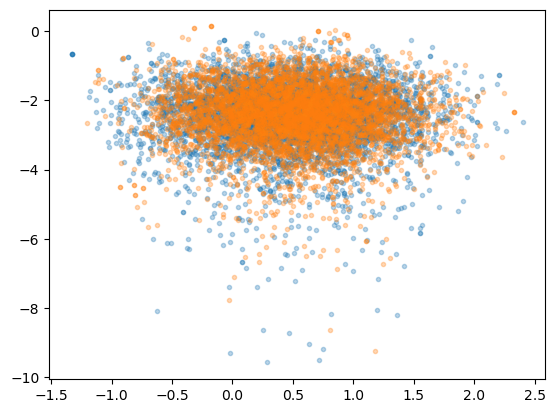

In [84]:
i = 1
j = 146
plt.scatter(draws4[:, i], draws4[:, j], marker=".", alpha=0.3)
plt.scatter(draws3[:, i], draws3[:, j], marker=".", alpha=0.3)

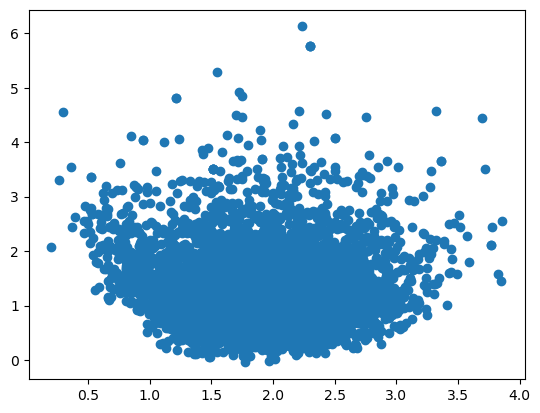

In [105]:
losses = jax.jit(jax.vmap(lambda point: loss(fit3, point[0, :], point[1, :]), 0))(points4)
plt.scatter(points4[:, 0, 241], np.log(losses))
#plt.ylim(0, 50)

In [95]:
from scipy import stats

In [96]:
regs = []
for i in range(points4.shape[-1]):
    regs.append(stats.linregress(points4[:, 0, i], np.log(losses)))

In [97]:
np.argsort([reg.pvalue for reg in regs])

array([145, 147, 150, 152, 156,   1, 190, 213, 149, 241, 185, 209, 179,
       103, 148,  40,  12,   7, 224, 144, 116, 127, 189,  35, 164, 180,
       191,  27, 207, 146, 119, 210, 198,  90, 195, 212,   4,  50, 240,
         8, 140, 154, 186, 204,  46, 242, 184,  51,  19, 170, 217, 216,
       225,  99, 102, 232,   5, 178, 196, 117,  73,  62, 218, 194, 104,
       199,  70,  48,  91,  97, 157, 115,  43, 200,  41, 165, 187, 192,
       122,  24, 193, 201, 138, 223, 214,  17, 206, 181, 171, 202,  75,
        25, 107,  39,  79,  44,  32,  10, 112, 169,  63, 124,  56,  72,
        31, 123, 233, 131, 162,  54, 205, 215,  36, 105, 175,  60, 121,
       167, 134,   9,  93, 109,  29,  67, 237,  95, 234,  76, 130,  71,
       120, 239,  69,  26,  11, 203, 173, 143,  30,  22,  49, 129,  66,
       227, 100, 176,  47, 168, 160, 236, 221,   0,  53,  85, 222, 230,
        20, 197,  86,  58,  42,  59,  82, 220, 101,  34,  61, 133, 211,
        13,  45, 114,  96, 126,  52, 125,  37,  18, 172,  15, 22

In [383]:
fit4, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit3,
    x=points4[:4000],
    batch_size=32,
    learning_rate=1e-4,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
    #optimizer=optax.adamaxw(1e-4),
)

 53%|█████▎    | 106/200 [02:25<02:09,  1.37s/it, train=-2.3239869102857424, val=-1.585647494710637 (Max patience reached)]


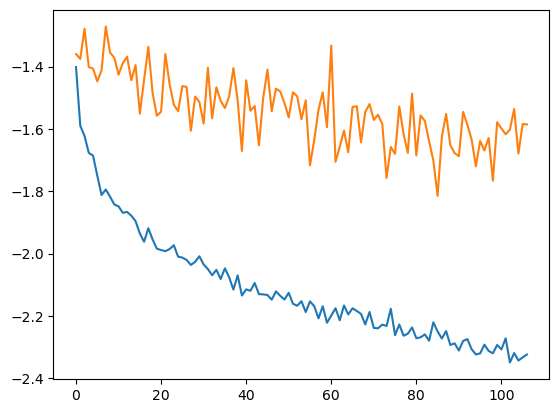

In [384]:
plt.plot(data["train"])
plt.plot(data["val"])

In [385]:
params, static = eqx.partition(vi_fit, eqx.is_array)
float(FisherLoss()(params, static, points4[4000:])), np.log(elbo_loss_large(params, static, key))

(3.1922564295862115, -2.642819270242864)

In [386]:
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points4[4000:])), np.log(elbo_loss_large(params, static, key))

(2.124862335934897, -1.6295144519829992)

In [387]:
params, static = eqx.partition(fit2, eqx.is_array)
float(FisherLoss()(params, static, points4[4000:])), np.log(elbo_loss_large(params, static, key))

(-0.13699849631749494, -2.4453965377189566)

In [388]:
params, static = eqx.partition(fit3, eqx.is_array)
float(FisherLoss()(params, static, points4[4000:])), np.log(elbo_loss_large(params, static, key))

(-1.163106069689546, -3.003013781409015)

In [389]:
params, static = eqx.partition(fit4, eqx.is_array)
float(FisherLoss()(params, static, points4[4000:])), np.log(elbo_loss_large(params, static, key))

(-1.4903153373001505, -3.3259352876350365)

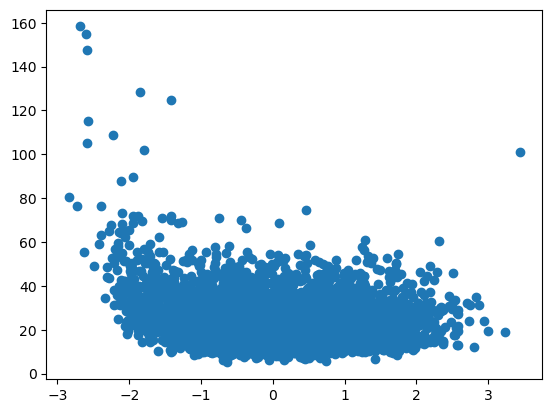

In [391]:
losses = jax.jit(jax.vmap(lambda point: loss(vi_fit, point[0, :], point[1, :]), 0))(points4)
plt.scatter(points4[:, 0, 1], (losses))
#plt.ylim(0, 100)

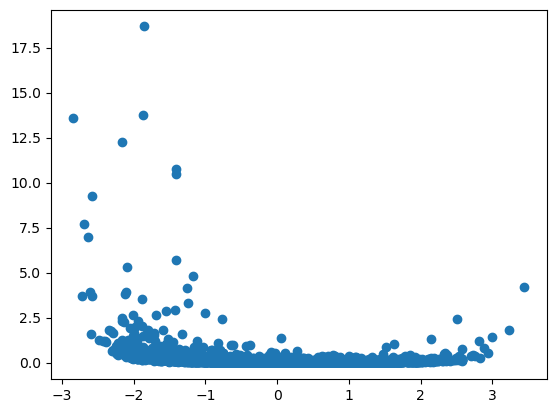

In [393]:
losses = jax.jit(jax.vmap(lambda point: loss(fit4, point[0, :], point[1, :]), 0))(points4)
plt.scatter(points4[:, 0, 1], (losses))
#plt.ylim(0, 100)

In [395]:
compiled5 = normalize_model(compiled, fit4)

trace5 = nutpie.sample(
    compiled5,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=123456,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.52,7
,1300,0,0.52,7
,1300,2,0.52,7
,1300,1,0.51,7
,1300,1,0.52,7


In [396]:
arviz.ess(trace5.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(6238.7476662)

In [397]:
points5, draws5, grads5 = unnormalize_points(trace5, fit4)

In [398]:
params, static = eqx.partition(fit4, eqx.is_array)
float(FisherLoss()(params, static, points5[4000:])), np.log(elbo_loss_large(params, static, key))

(-1.6346357197719228, -3.3259352876350365)

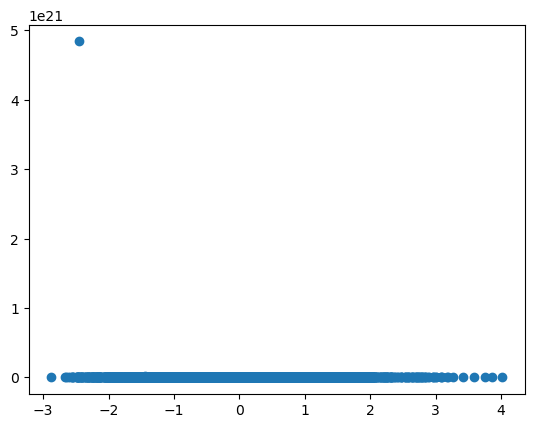

In [399]:
losses = jax.jit(jax.vmap(lambda point: loss(fit4, point[0, :], point[1, :]), 0))(points5)
plt.scatter(points5[:, 0, 1], np.exp(losses))
#plt.ylim(0, 100)

In [400]:
from scipy import stats

In [401]:
tests = []
for i in range(draws.shape[-1]):
    tests.append(stats.ks_2samp(draws4[:, i], draws5[:, i]))

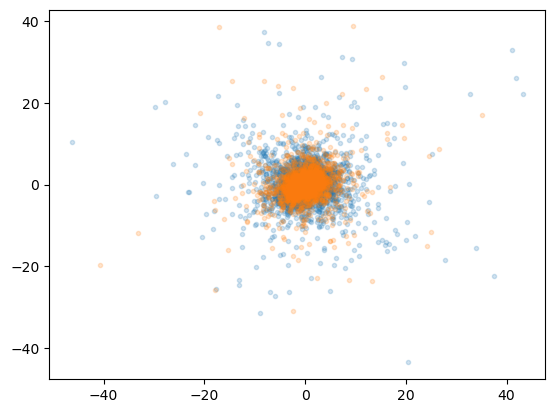

In [402]:
plt.scatter(draws[:, 37], draws[:, -3], marker=".", alpha=0.2)
plt.scatter(draws5[:, 37], draws5[:, -3], marker=".", alpha=0.2)

In [403]:
tests[37]

KstestResult(statistic=0.0116, pvalue=0.8896523693694147, statistic_location=-2.3728927119409176, statistic_sign=-1)

In [404]:
(np.array([test.pvalue for test in tests]))

array([0.61040979, 0.67778775, 0.42096355, 0.22957852, 0.79206695,
       0.77641759, 0.79206695, 0.29207986, 0.54418748, 0.711289  ,
       0.95721723, 0.95721723, 0.22957852, 0.61040979, 0.93254163,
       0.92285766, 0.61040979, 0.80737617, 0.20237432, 0.57704555,
       0.46535783, 0.22957852, 0.88965237, 0.77641759, 0.94972795,
       0.40671817, 0.1486103 , 0.27001861, 0.40671817, 0.57704555,
       0.66093855, 0.87728867, 0.20237432, 0.12939324, 0.66093855,
       0.99969816, 0.52800527, 0.88965237, 0.69458348, 0.27001861,
       0.33994536, 0.98742588, 0.94972795, 0.16265087, 0.48067531,
       0.711289  , 0.80737617, 0.46535783, 0.90138859, 0.711289  ,
       0.72786585, 0.15550391, 0.14196445, 0.32751062, 0.43549127,
       0.43549127, 0.79206695, 0.20237432, 0.21115229, 0.36574413,
       0.95721723, 0.61040979, 0.66093855, 0.43549127, 0.57704555,
       0.43549127, 0.85082195, 0.92285766, 0.86433252, 0.0522378 ,
       0.61040979, 0.67778775, 0.94972795, 0.57704555, 0.45029

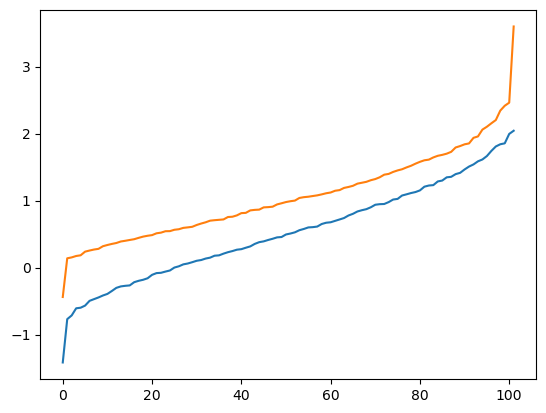

In [405]:
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.cov(samples.T))))
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.diag(diag ** 2))))

In [406]:
input_dims = [("a", "b"), ("a",)]
core_sig = [(),()->("c")]

# it follows that
output_dims_max = [("a", "b", "c")]

SyntaxError: invalid syntax (349053797.py, line 2)

In [553]:
import numpy as np
from math import prod


class Space:
    name: str | None
    bases: set["Space"] | None
    dual: "Space"
    length: int

    def __init__(self, name, length):
        self.name = name
        self.length = length
        self.bases = set()
        self._dual = Dual(self)

    def dual(self):
        return self._dual

    def __repr__(self):
        if self.name is not None:
            return self.name
        return f"{type(self).__name__}({self.bases})"


class Dim(Space):
    def __init__(self, name: str, length: int):
        super().__init__(name, length)


class Dual(Space):
    base: Space

    def __init__(self, base):
        #super().__init__()
        self.bases = {base}
        self.base = base
        self._dual = base
        self.length = base.length

    def __repr__(self):
        return f"Dual({self.base})"


class Stack(Space):
    def __init__(self, bases: set[Space]):
        super().__init__(None, prod(base.length for base in bases))
        self.bases = bases


class TensorType:
    dims: set[Space]
    dtype: np.dtype

    def __init__(self, *dims, dtype=np.float64):
        dims_set = set(dims)
        if len(dims_set) != len(dims):
            raise ValueError("Dimensions must be unique")
        dims = dims_set
        duals = {dim.dual() for dim in dims}
        if dims.intersection(duals):
            raise ValueError("Can't contain dimension and its dual")
        self.dtype = dtype
        self.dims = dims

    def __repr__(self):
        return f"TensorType({self.dims}, dtype={self.dtype.__name__})"


class Tensor:
    ttype: TensorType
    value: np.ndarray
    storage_order: list[Space]

    def __init__(self, value: np.ndarray, *dims):
        ttype = TensorType(*dims, dtype=value.dtype)
        if len(ttype.dims) != value.ndim:
            raise ValueError("Rank mismatch between values and dims")
        self.storage_order = list(dims)
        self.ttype = ttype
        self.value = value
        if not all(dim.length == length for dim, length in zip(dims, value.shape)):
            raise ValueError("Incorrect shape for data")

    def __repr__(self):
        return f"Tensor with dims {self.storage_order}\n{str(self.value)}"




class Op:
    def __call__(self, *inputs):
        


def zeros(dtype, *dims):
    dtype = np.dtype(dtype)
    vals = np.zeros([dim.length for dim in dims], dtype=dtype)
    return Tensor(vals, *dims)

In [554]:
a = Dim("a", 5)
b = Dim("b", 6)

In [555]:
a.dual()

Dual(a)

In [556]:
x = TensorType(a, b)
x

TensorType({b, a}, dtype=float64)

In [557]:
Tensor(np.zeros((5, 6)), a, b)

Tensor with dims [a, b]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

In [558]:
zeros(np.float64, a, b)

Tensor with dims [a, b]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]